#Find the nuclei in divergent images to advance medical discovery

In this dataset we will classify microscopic images of Nucleus  from the 2018 data  Data Science Bowl [Find the nuclei in divergent images to advance medical discovery ](http://www.kaggle.com/c/data-science-bowl-2018) dataset.This dataset contains a large number of segmented nuclei images.  You'll preprocess the images, then train a U-net convolutional neural network on all the samples. The images need to be normalize and we use Data augmentation because we have small dataset. we are apply convolutional, max pooling,concatenate and upsampling At the end, you'll get to see your neural network's predictions on the sample images.
# Get the data
you can download the data hear- [Find the nuclei in divergent images to advance medical discovery ](https://www.kaggle.com/c/data-science-bowl-2018/data)



In [1]:
!pip install tqdm
!curl -LO https://raw.github.com/drj11/pypng/master/code/png.py

import numpy as np 
import pandas as pd
import sys
from urllib.request import urlretrieve
from os.path import isfile, isdir
import zipfile
import os
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from skimage.io import imread
from skimage.transform import resize 
from keras.layers import Input
from keras.layers import Lambda
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.models import load_model
import keras.backend as K

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   97k  100   97k    0     0    97k      0  0:00:01 --:--:--  0:00:01   97k


Using TensorFlow backend.


In [2]:
cwd = os.getcwd()

testpath = os.path.join(cwd, 'data', 'test')
trainpath = os.path.join(cwd, 'data', 'train')

if not os.path.exists(trainpath):
    os.makedirs(trainpath)

if not os.path.exists(testpath):
    os.makedirs(testpath)

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

test_url = 'https://storage.googleapis.com/kaggle-competitions-data/kaggle/8089/stage1_test.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1527516301&Signature=PsQNWaZzX60IZTGFDisXXn3RVGSm6VqYHdNlhzA4U2kSZ5o86ANFFENXvFDHdf75f8%2F0chchV0pff01MtP309BPULgddPzFcrdu1fap3Ud1D81ToJ%2BZWdDqVc3CVqmS0AtRjeQbSReuuDuoS1%2Ff%2B%2BHWOtUjbYdhMeVjy7ptLzt7XTezLpiUZ54biU2Wg%2BW7Vp6PDXJXB7Izeg%2FI0kvqivCk6XWH6Dy%2B5U%2FJDKVchr2Q%2B6tbmJsHal8wRXWYPCMuSrZrKhNde9la6BWcBdgSxcc7L7bMBzi6unx4Hu7xzJV%2FlbbbRyT1ESzQmoO39enytA47BDiihWRK0ZDh9eQ%2FSAg%3D%3D'      
train_url = 'https://storage.googleapis.com/kaggle-competitions-data/kaggle/8089/stage1_train.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1527516252&Signature=MP2TYKkHKpn2UmfHYDsZP5YI1ZPXE09%2BzVEtCdBTI6PHO1OWCngiejipodK0xj2DMdh6Z6flsrK3J8ilBZ%2Be%2Fw1brci476y9Id1euMW8XjeEWOPrFKbmmmw%2FH3JrrTjTM3ynb%2BviaD4q4eutyvARureOPdRvLKRhRzpvj035%2FTrbKebHIN7pEq9EP3fdtXYOgDudLm0NurLlzF%2BYGLqOBntLBBJ2pU%2BNGOpcrb1cNs7eXc6lslyHYJqETY6YxkEljX0iVIaN%2F1EnlQbAFpOBOMr8q54XqkTDX0%2BybZfS7ke9L6Eu0pIqONePGaPfZnvtPBFGKB54h0jMzYntAbrWMA%3D%3D'
if not isfile('train.zip'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Download Train Data') as pbar:
        urlretrieve(
            train_url,
            'train.zip',
            pbar.hook)
        
        
if not isfile('test.zip'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Download Test Data') as pbar:
        urlretrieve(
            test_url,  
            'test.zip',
            pbar.hook)

with zipfile.ZipFile('train.zip') as zip_file:
    cwd = os.getcwd()
    zip_file.extractall(os.path.join(cwd, 'data', 'train'))
    zip_file.close()

with zipfile.ZipFile('test.zip') as zip_file:
    cwd = os.getcwd()
    zip_file.extractall(os.path.join(cwd, 'data', 'test'))
    zip_file.close()

print('All files Found')

All files Found


In [0]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_DEPTH = 3

TRAIN_PATH =  os.path.join('data', 'train')
TEST_PATH = os.path.join('data', 'test')

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [4]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)

print('Getting And Resizing Training images and Masks...')
sys.stdout.flush()

for index, id_ in tqdm(enumerate(train_ids), total = len(train_ids)):
    path = os.path.join(TRAIN_PATH, id_)
    img = imread(os.path.join(path, 'images', id_) +  '.png')[:, :, :IMG_DEPTH]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode= 'constant', preserve_range=True)
    X_train[index] = img
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
    for mask_file in next(os.walk(os.path.join(path, 'masks')))[2]:
        mask_ = imread(os.path.join(path, 'masks', mask_file))
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_HEIGHT), mode = 'constant', preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[index] = mask

X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH), dtype = np.uint8)
    
print('Getting And Resizing Testing images and Masks...')
sys.stdout.flush()

for index, id_ in tqdm(enumerate(test_ids), total = len(test_ids)):
    path = os.path.join(TEST_PATH, id_)
    img = imread(os.path.join(path, 'images', id_) +  '.png')[:, :, :IMG_DEPTH]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode= 'constant', preserve_range=True)
    X_test[index] = img

print('done')
print('We have {} Train images and {} Test images!'.format(X_train.shape[0],  X_test.shape[0]))

Getting And Resizing Training images and Masks...


100%|██████████| 670/670 [01:45<00:00,  6.35it/s]

Getting And Resizing Testing images and Masks...



100%|██████████| 65/65 [00:00<00:00, 69.61it/s]

done
We have 670 Train images and 65 Test images!


# Visulization Images And Masks
we have 670 Training examples, now i am generating random index and visulize images and mask, i make `display_images` method, this method has three inputs, `X_train`, `Y_train` and `id_`. the `id_` input conain indexes. i am randomly generate id_ and visulize images and mask, run below comand.

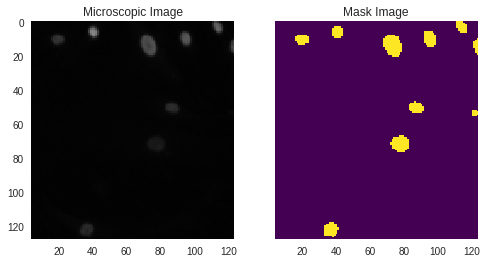

In [5]:
def display_images(id_, X_train, Y_train):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharey=True)
    ax1.set_title('Microscopic Image')
    ax1.grid(False)
    ax1.imshow(X_train[id_])

    ax2.set_title('Mask Image')
    ax2.grid(False)
    ax2.imshow(np.squeeze(Y_train[id_]), cmap="viridis")
    plt.show()

id_ = np.random.randint(len(X_train))
display_images(9, X_train, Y_train)

## Implement Preprocess Functions
### Normalize
In the cell below, implement the `normalize` function to take in image data, `X_train and X_test`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive.  The return object should be the same shape as `X_train and X_test`.

In [0]:
def normalize(x):
    samples = []
    for sample in x:
        samples.append(sample / 255)
    return np.array(samples)

X_train = normalize(X_train)
X_test = normalize(X_test)

# Metrics

This project is evaluated on the mean average precision at different intersection over union (IoU) thresholds. The IoU of a proposed set of object pixels and a set of true object pixels is calculated as:

\begin{align}
IoU(A,B) = \frac{A \cap B}{ A \cup B}.
\end{align}

The metric sweeps over a range of IoU thresholds, at each point calculating an average precision value. The threshold values range from 0.5 to 0.95 with a step size of 0.05: (0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95). In other words, at a threshold of 0.5, a predicted object is considered a "hit" if its intersection over union with a ground truth object is greater than 0.5.
At each threshold value tt, a precision value is calculated based on the number of true positives (TP), false negatives (FN), and false positives (FP) resulting from comparing the predicted object to all ground truth objects:

\begin{align}
\frac{TP(t)}{TP(t) + FP(t) + FN(t)}.
\end{align}

A true positive is counted when a single predicted object matches a ground truth object with an IoU above the threshold. A false positive indicates a predicted object had no associated ground truth object. A false negative indicates a ground truth object had no associated predicted object. The average precision of a single image is then calculated as the mean of the above precision values at each IoU threshold:

\begin{align}
\frac{1}{|thresholds|} \sum_t \frac{TP(t)}{TP(t) + FP(t) + FN(t)}.
\end{align}

Lastly, the score returned by the project metric is the mean taken over the individual average precisions of each image in the test dataset.

Reference: 

[https://www.kaggle.com/c/data-science-bowl-2018#evaluation](https://www.kaggle.com/c/data-science-bowl-2018#evaluation)

In [0]:
def iou(y_true, prediction):
    prece = []
    for e in np.arange(0.5, 1.0, 0.05):
        pred = tf.to_int32(prediction > e)
        score, opt = tf.metrics.mean_iou(y_true, pred, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([opt]):
            score = tf.identity(score)
        prece.append(score)
    return K.mean(K.stack(prece),axis=0)

# Build the network
In this project we build U-net Convolutional Networks for Image Segmentation.The u-net is convolutional network architecture for fast and precise segmentation of images. Up to now it has outperformed the prior best method (a sliding-window convolutional network) on the ISBI challenge for segmentation of neuronal structures in electron microscopic stacks. It has won the Grand Challenge for Computer-Automated Detection of Caries in Bitewing Radiography at ISBI 2015, and it has won the Cell Tracking Challenge at ISBI 2015 on the two most challenging transmitted light microscopy categories (Phase contrast and DIC microscopy) by a large margin . and we use this CNN archistructure. [Papers](https://arxiv.org/pdf/1505.04597.pdf)
![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [8]:
def create_model():
    
    inputs = Input((IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH))
#     x = Lambda(lambda x : x / 255) (inputs)
    
    conv = Conv2D(16, (3, 3), padding='same', activation='relu')(inputs)
    conv = Conv2D(16, (3, 3), padding='same', activation='relu')(conv)
    p = MaxPooling2D((2, 2))(conv)
    
    conv1 = Conv2D(32, (3, 3), padding='same', activation='relu')(p)
    conv1 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv1)
    p1 = MaxPooling2D((2, 2))(conv1)
    
    conv2 = Conv2D(64, (3, 3), padding='same', activation='relu')(p1)
    conv2 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv2)
    p2 = MaxPooling2D((2, 2))(conv2)
    
    conv3 = Conv2D(128, (3, 3), padding='same', activation='relu')(p2)
    conv3 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv3)
    p3 = MaxPooling2D((2, 2))(conv3)
    
    conv4 = Conv2D(256, (3, 3), padding='same', activation='relu')(p3)
    conv4 = Conv2D(256, (3, 3), padding='same', activation='relu')(conv4)
    
    m = concatenate([
        Conv2D(128, (2, 2), padding='same', activation='relu')(UpSampling2D(size = (2, 2)) (conv4)),
        conv3
    ])
    
    conv5 = Conv2D(128, (3, 3), padding='same', activation='relu')(m)
    conv5 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv5)
    
    m1 = concatenate([
        Conv2D(64, (2, 2), padding='same', activation='relu')(UpSampling2D(size = (2, 2)) (conv5)),
        conv2
    ])
    
    conv6 = Conv2D(64, (3, 3), padding='same', activation='relu')(m1)
    conv6 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv6)
    
    m2 = concatenate([
        Conv2D(32, (2, 2), padding='same', activation='relu')(UpSampling2D(size = (2, 2)) (conv6)),
        conv1
    ])
    
    conv7 = Conv2D(32, (3, 3), padding='same', activation='relu')(m2)
    conv7 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv7)
    
    m3 = concatenate([
        Conv2D(16, (2, 2), padding='same', activation='relu')(UpSampling2D(size = (2, 2)) (conv7)),
        conv
    ])
    
    conv8 = Conv2D(16, (3, 3), padding='same', activation='relu')(m3)
    conv8 = Conv2D(16, (3, 3), padding='same', activation='relu')(conv8)
    
    output = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(conv8)
    
    model = Model(inputs = inputs, outputs = output)
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = [iou])
    return model
    
model = create_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

# Train the model
now we train our model, before we train the model we set our callbacks
*   **ModelCheckpoint** :  For example: if filepath  is **model-capstone_project_udacity_by_jimit_jaishwal**, then the model checkpoints will be saved with the epoch number and the validation loss in the filename.
*  **EarlyStopping** : Stop training when a monitored quantity has stopped improving.

In [9]:
stoper = EarlyStopping(verbose=1, patience=7)
FILE_PATH = 'model-capstone_project_udacity_by_jimit_jaishwal.sh'
checkpointer = ModelCheckpoint(FILE_PATH, verbose=1, save_best_only=True)



BATCH = 4
EPOCH = 40

model.fit(epochs= EPOCH,
          x = X_train,
          y = Y_train, shuffle = False,
          batch_size = BATCH,
          validation_split = 0.1,
          callbacks=[stoper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/40
603/603 [==============================] - 14s 24ms/step - loss: 0.3557 - iou: 0.4249 - val_loss: 0.2434 - val_iou: 0.4439

Epoch 00001: val_loss improved from inf to 0.24344, saving model to model-capstone_project_udacity_by_jimit_jaishwal.sh
Epoch 2/40
603/603 [==============================] - 11s 18ms/step - loss: 0.1727 - iou: 0.4715 - val_loss: 0.1433 - val_iou: 0.5204

Epoch 00002: val_loss improved from 0.24344 to 0.14334, saving model to model-capstone_project_udacity_by_jimit_jaishwal.sh
Epoch 3/40
108/603 [====>.........................] - ETA: 8s - loss: 0.1222 - iou: 0.5322

603/603 [==============================] - 11s 18ms/step - loss: 0.1256 - iou: 0.5629 - val_loss: 0.1217 - val_iou: 0.5975

Epoch 00003: val_loss improved from 0.14334 to 0.12168, saving model to model-capstone_project_udacity_by_jimit_jaishwal.sh
Epoch 4/40
603/603 [==============================] - 11s 18ms/step - loss: 0.1112 - iou: 0.6239 - val_loss: 0.1008 - val_iou: 0.6449

Epoch 00004: val_loss improved from 0.12168 to 0.10083, saving model to model-capstone_project_udacity_by_jimit_jaishwal.sh
Epoch 5/40
236/603 [==========>...................] - ETA: 6s - loss: 0.1000 - iou: 0.6533

603/603 [==============================] - 11s 18ms/step - loss: 0.1014 - iou: 0.6621 - val_loss: 0.0972 - val_iou: 0.6772

Epoch 00005: val_loss improved from 0.10083 to 0.09717, saving model to model-capstone_project_udacity_by_jimit_jaishwal.sh
Epoch 6/40
603/603 [==============================] - 11s 18ms/step - loss: 0.0935 - iou: 0.6901 - val_loss: 0.0995 - val_iou: 0.7013

Epoch 00006: val_loss did not improve from 0.09717
Epoch 7/40
296/603 [=============>................] - ETA: 5s - loss: 0.0880 - iou: 0.7066

603/603 [==============================] - 11s 18ms/step - loss: 0.0887 - iou: 0.7108 - val_loss: 0.0902 - val_iou: 0.7195

Epoch 00007: val_loss improved from 0.09717 to 0.09025, saving model to model-capstone_project_udacity_by_jimit_jaishwal.sh
Epoch 8/40
603/603 [==============================] - 11s 18ms/step - loss: 0.0910 - iou: 0.7267 - val_loss: 0.0903 - val_iou: 0.7333

Epoch 00008: val_loss did not improve from 0.09025
Epoch 9/40
288/603 [=============>................] - ETA: 5s - loss: 0.0824 - iou: 0.7367

603/603 [==============================] - 11s 18ms/step - loss: 0.0832 - iou: 0.7396 - val_loss: 0.0803 - val_iou: 0.7454

Epoch 00009: val_loss improved from 0.09025 to 0.08029, saving model to model-capstone_project_udacity_by_jimit_jaishwal.sh
Epoch 10/40
603/603 [==============================] - 11s 18ms/step - loss: 0.0818 - iou: 0.7506 - val_loss: 0.0779 - val_iou: 0.7554

Epoch 00010: val_loss improved from 0.08029 to 0.07789, saving model to model-capstone_project_udacity_by_jimit_jaishwal.sh
Epoch 11/40
252/603 [===========>..................] - ETA: 5s - loss: 0.0787 - iou: 0.7577

603/603 [==============================] - 11s 18ms/step - loss: 0.0816 - iou: 0.7599 - val_loss: 0.0798 - val_iou: 0.7639

Epoch 00011: val_loss did not improve from 0.07789
Epoch 12/40
603/603 [==============================] - 11s 18ms/step - loss: 0.0775 - iou: 0.7680 - val_loss: 0.0734 - val_iou: 0.7717

Epoch 00012: val_loss improved from 0.07789 to 0.07335, saving model to model-capstone_project_udacity_by_jimit_jaishwal.sh
Epoch 13/40
372/603 [=================>............] - ETA: 3s - loss: 0.0734 - iou: 0.7740

603/603 [==============================] - 11s 18ms/step - loss: 0.0763 - iou: 0.7752 - val_loss: 0.0766 - val_iou: 0.7783

Epoch 00013: val_loss did not improve from 0.07335
Epoch 14/40
603/603 [==============================] - 11s 18ms/step - loss: 0.0763 - iou: 0.7813 - val_loss: 0.0795 - val_iou: 0.7841

Epoch 00014: val_loss did not improve from 0.07335
Epoch 15/40
452/603 [=====================>........] - ETA: 2s - loss: 0.0728 - iou: 0.7862

603/603 [==============================] - 11s 18ms/step - loss: 0.0747 - iou: 0.7867 - val_loss: 0.0728 - val_iou: 0.7892

Epoch 00015: val_loss improved from 0.07335 to 0.07283, saving model to model-capstone_project_udacity_by_jimit_jaishwal.sh
Epoch 16/40
603/603 [==============================] - 11s 18ms/step - loss: 0.0726 - iou: 0.7916 - val_loss: 0.0736 - val_iou: 0.7939

Epoch 00016: val_loss did not improve from 0.07283
Epoch 17/40
316/603 [==============>...............] - ETA: 4s - loss: 0.0694 - iou: 0.7952

603/603 [==============================] - 11s 18ms/step - loss: 0.0723 - iou: 0.7960 - val_loss: 0.0745 - val_iou: 0.7980

Epoch 00017: val_loss did not improve from 0.07283
Epoch 18/40
603/603 [==============================] - 11s 18ms/step - loss: 0.0706 - iou: 0.8000 - val_loss: 0.0756 - val_iou: 0.8019

Epoch 00018: val_loss did not improve from 0.07283
Epoch 19/40
424/603 [====================>.........] - ETA: 3s - loss: 0.0698 - iou: 0.8032

603/603 [==============================] - 11s 18ms/step - loss: 0.0726 - iou: 0.8036 - val_loss: 0.0737 - val_iou: 0.8051

Epoch 00019: val_loss did not improve from 0.07283
Epoch 20/40
603/603 [==============================] - 11s 18ms/step - loss: 0.0685 - iou: 0.8068 - val_loss: 0.0696 - val_iou: 0.8083

Epoch 00020: val_loss improved from 0.07283 to 0.06963, saving model to model-capstone_project_udacity_by_jimit_jaishwal.sh
Epoch 21/40
408/603 [===================>..........] - ETA: 3s - loss: 0.0658 - iou: 0.8095

603/603 [==============================] - 11s 18ms/step - loss: 0.0679 - iou: 0.8099 - val_loss: 0.0720 - val_iou: 0.8113

Epoch 00021: val_loss did not improve from 0.06963
Epoch 22/40
603/603 [==============================] - 11s 18ms/step - loss: 0.0666 - iou: 0.8128 - val_loss: 0.0696 - val_iou: 0.8141

Epoch 00022: val_loss improved from 0.06963 to 0.06956, saving model to model-capstone_project_udacity_by_jimit_jaishwal.sh
Epoch 23/40
396/603 [==================>...........] - ETA: 3s - loss: 0.0659 - iou: 0.8150

603/603 [==============================] - 11s 18ms/step - loss: 0.0684 - iou: 0.8154 - val_loss: 0.0674 - val_iou: 0.8166

Epoch 00023: val_loss improved from 0.06956 to 0.06742, saving model to model-capstone_project_udacity_by_jimit_jaishwal.sh
Epoch 24/40
603/603 [==============================] - 11s 18ms/step - loss: 0.0657 - iou: 0.8178 - val_loss: 0.0708 - val_iou: 0.8190

Epoch 00024: val_loss did not improve from 0.06742
Epoch 25/40
312/603 [==============>...............] - ETA: 5s - loss: 0.0625 - iou: 0.8196

603/603 [==============================] - 11s 18ms/step - loss: 0.0650 - iou: 0.8201 - val_loss: 0.0728 - val_iou: 0.8212

Epoch 00025: val_loss did not improve from 0.06742
Epoch 26/40
603/603 [==============================] - 11s 18ms/step - loss: 0.0641 - iou: 0.8223 - val_loss: 0.0677 - val_iou: 0.8234

Epoch 00026: val_loss did not improve from 0.06742
Epoch 27/40
416/603 [===================>..........] - ETA: 3s - loss: 0.0617 - iou: 0.8241

603/603 [==============================] - 11s 18ms/step - loss: 0.0640 - iou: 0.8244 - val_loss: 0.0788 - val_iou: 0.8253

Epoch 00027: val_loss did not improve from 0.06742
Epoch 28/40
603/603 [==============================] - 11s 18ms/step - loss: 0.0676 - iou: 0.8262 - val_loss: 0.0674 - val_iou: 0.8270

Epoch 00028: val_loss improved from 0.06742 to 0.06740, saving model to model-capstone_project_udacity_by_jimit_jaishwal.sh
Epoch 29/40
392/603 [==================>...........] - ETA: 3s - loss: 0.0617 - iou: 0.8276

603/603 [==============================] - 11s 18ms/step - loss: 0.0657 - iou: 0.8278 - val_loss: 0.0792 - val_iou: 0.8286

Epoch 00029: val_loss did not improve from 0.06740
Epoch 30/40
603/603 [==============================] - 11s 18ms/step - loss: 0.0644 - iou: 0.8295 - val_loss: 0.0690 - val_iou: 0.8302

Epoch 00030: val_loss did not improve from 0.06740
Epoch 31/40
440/603 [====================>.........] - ETA: 2s - loss: 0.0615 - iou: 0.8308

603/603 [==============================] - 11s 18ms/step - loss: 0.0632 - iou: 0.8310 - val_loss: 0.0684 - val_iou: 0.8317

Epoch 00031: val_loss did not improve from 0.06740
Epoch 32/40
603/603 [==============================] - 11s 18ms/step - loss: 0.0612 - iou: 0.8326 - val_loss: 0.0648 - val_iou: 0.8333

Epoch 00032: val_loss improved from 0.06740 to 0.06478, saving model to model-capstone_project_udacity_by_jimit_jaishwal.sh
Epoch 33/40
388/603 [==================>...........] - ETA: 3s - loss: 0.0563 - iou: 0.8338

603/603 [==============================] - 11s 18ms/step - loss: 0.0600 - iou: 0.8341 - val_loss: 0.0626 - val_iou: 0.8348

Epoch 00033: val_loss improved from 0.06478 to 0.06264, saving model to model-capstone_project_udacity_by_jimit_jaishwal.sh
Epoch 34/40
603/603 [==============================] - 11s 18ms/step - loss: 0.0596 - iou: 0.8356 - val_loss: 0.0723 - val_iou: 0.8362

Epoch 00034: val_loss did not improve from 0.06264
Epoch 35/40
296/603 [=============>................] - ETA: 5s - loss: 0.0573 - iou: 0.8366

603/603 [==============================] - 11s 18ms/step - loss: 0.0613 - iou: 0.8369 - val_loss: 0.0655 - val_iou: 0.8375

Epoch 00035: val_loss did not improve from 0.06264
Epoch 36/40
603/603 [==============================] - 11s 18ms/step - loss: 0.0598 - iou: 0.8382 - val_loss: 0.0716 - val_iou: 0.8388

Epoch 00036: val_loss did not improve from 0.06264
Epoch 37/40
456/603 [=====================>........] - ETA: 2s - loss: 0.0563 - iou: 0.8393

603/603 [==============================] - 11s 18ms/step - loss: 0.0587 - iou: 0.8395 - val_loss: 0.0687 - val_iou: 0.8400

Epoch 00037: val_loss did not improve from 0.06264
Epoch 38/40
603/603 [==============================] - 11s 18ms/step - loss: 0.0587 - iou: 0.8407 - val_loss: 0.0686 - val_iou: 0.8412

Epoch 00038: val_loss did not improve from 0.06264
Epoch 39/40
488/603 [=======================>......] - ETA: 1s - loss: 0.0556 - iou: 0.8418

603/603 [==============================] - 11s 18ms/step - loss: 0.0570 - iou: 0.8419 - val_loss: 0.0688 - val_iou: 0.8424

Epoch 00039: val_loss did not improve from 0.06264
Epoch 40/40
603/603 [==============================] - 11s 18ms/step - loss: 0.0568 - iou: 0.8430 - val_loss: 0.0689 - val_iou: 0.8436

Epoch 00040: val_loss did not improve from 0.06264
Epoch 00040: early stopping


#  Prediction
Now we are predicting a validation train and test dataset and  check how accurate our CNN model?

In [0]:
model = load_model(filepath=FILE_PATH, custom_objects={'iou' : iou})

predict_train_set = model.predict(X_train[:int(X_train.shape[0] * 0.9)])
predict_val_set = model.predict(X_train[int(X_train.shape[0] * 0.9):])
predict_test_set = model.predict(X_test)

def set_threshold(preds):
    return (preds > 0.5).astype(np.uint8)

predict_train_set = set_threshold(predict_train_set)
predict_val_set = set_threshold(predict_val_set)
predict_test_set = set_threshold(predict_test_set)

# Visualize Train Prediction

now we test and visualize our predicting train results and check how well model perform. 

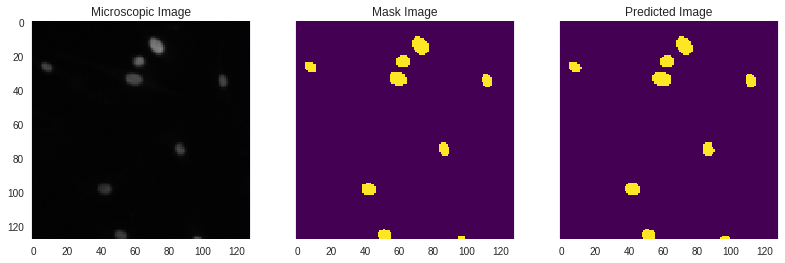

In [11]:
def display_results(id_, X_train, Y_train, predicted):
    fig, arr = plt.subplots(1, 3, figsize=(13.4, 4), sharey=True,sharex=True)
    arr[0].set_title('Microscopic Image')
    arr[0].grid(False)
    arr[0].imshow(X_train[id_])

    arr[1].set_title('Mask Image')
    arr[1].grid(False)
    arr[1].imshow(np.squeeze(Y_train[id_]), cmap="viridis")
    
    arr[2].imshow(np.squeeze(predicted[id_]), cmap="viridis")
    arr[2].set_title('Predicted Image')
    arr[2].grid(False)
        
id_ = np.random.randint(0, len(predict_train_set))
display_results(id_, X_train, Y_train, predict_train_set)

# Calculate Classification Accuracy on Test Set

In [13]:
score = model.evaluate(X_test, predict_test_set, verbose=1)
print('\n', 'IoU Score :', score[1])
print('\n', 'Test Loss :', score[0])

65/65 [==============================] - 0s 5ms/step

 IoU Score : 0.8697974617664631

 Test Loss : 0.05526367325622302


# Visualize Test Prediction

To test how well our model working i create 4 random images from test images and check how prediction is?

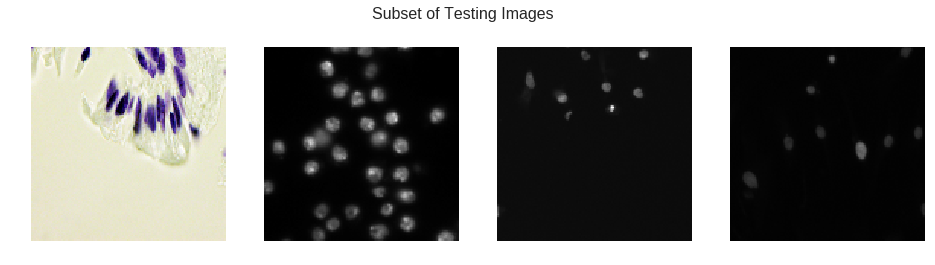

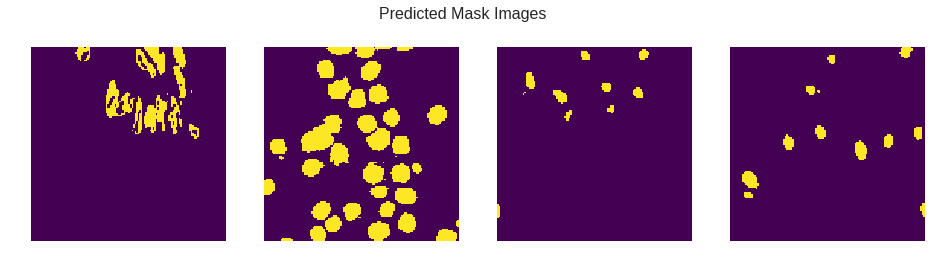

In [14]:
number_list = []

for i in range(4):
    rand = np.random.randint(0, len(X_test))
    number_list.append(rand)


# visualize subset of training data
fig = plt.figure(figsize=(16,4))
for i in range(0, len(number_list)):
    ax = fig.add_subplot(1, 4, i+1)
    ax.grid(False)
    ax.imshow(X_test[i])
    ax.axis('off')
fig.suptitle('Subset of Testing Images',  fontsize=16)
plt.show()

# visualize augmented images
fig = plt.figure(figsize=(16,4))

for i in range(0, len(number_list)):
    ax = fig.add_subplot(1, 4, i+1)
    ax.grid(False)
    ax.axis('off')
    ax.imshow(np.squeeze(predict_test_set[i]),  cmap="viridis")
fig.suptitle('Predicted Mask Images', fontsize=16)
plt.show()

# Save Results in local disks
now we save all predicted test images in local disks.

In [15]:
import png 
resultspath = os.path.join(cwd, 'results')

if not os.path.exists(resultspath):
    os.makedirs(resultspath)

for index, image in enumerate(predict_test_set):
    image_id = test_ids[index] + '.png'
    png.from_array(image, 'L').save(os.path.join(resultspath, image_id))  

print('All images saved successfully!')

All images saved successfully!
